# Exploratory data analysis for 5 years test dataset

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

The first step is a pre-processing and cleaning of the dataset.

In [3]:
file = open('config2.json', encoding='utf-8')
config_file = json.load(file)
file.close()

In [4]:
def cleanning_data(data):
    clean = data.copy()
    sort_to = ''

    for i in config_file:
        if (config_file[i] == 'dateTime'):
            clean[i] = pd.to_datetime(clean[i], dayfirst=True)
            sort_to = i
        elif (config_file[i] == 'str'):
            clean[i] = clean[i].str.strip()
        elif (config_file[i] == 'float'):
            clean[i] = clean[i].apply(lambda x: number_cleanning(x, True))
        elif (config_file[i] == 'int'):
            clean[i] = clean[i].apply(lambda x: number_cleanning(x))

    return clean.sort_values(by=sort_to, ascending=True)

def number_cleanning(num, isFloat=False):
    thou_sep = ','
    ans = str(num).lower()
    ans = ans.replace(thou_sep, '')

    tens = dict(k='E+03', m='E+06', b='E+09')
    for word, exp in tens.items():
        ans = ans.replace(word, exp)

    regex_num = '^\D*|\D*$'
    ans = re.sub(regex_num, '', ans)

    if (isFloat):
        return float(ans)
    else:
        return int(float(ans)//1)

In [5]:
path = '../data/raw/TES 5 años.csv'
df = pd.read_csv(path, sep=',', header=0, decimal='.')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Fecha     3865 non-null   object 
 1   Último    3865 non-null   float64
 2   Apertura  3865 non-null   float64
 3   Máximo    3865 non-null   float64
 4   Mínimo    3865 non-null   float64
 5   % var.    3865 non-null   object 
dtypes: float64(4), object(2)
memory usage: 181.3+ KB


In [6]:
df2 = cleanning_data(df)
df2 = df2.drop(index = df2[df2['Fecha'] == '2018-11-02'].index)
df2

,Fecha,Último,Apertura,Máximo,Mínimo,% var.
3864,2007-01-23,9.315,0.000,0.000,0.000,0.59
3863,2007-02-05,9.351,0.000,0.000,0.000,0.39
3862,2007-03-08,9.815,0.000,0.000,0.000,4.96
3861,2007-03-12,9.772,0.000,0.000,0.000,0.44
3860,2007-03-13,9.771,0.000,0.000,0.000,0.01
...,...,...,...,...,...,...
4,2022-05-17,11.007,10.900,11.095,10.890,0.98
3,2022-05-18,10.950,11.079,11.079,10.950,0.52
2,2022-05-19,10.800,10.781,10.845,10.700,1.37
1,2022-05-20,10.620,10.820,10.840,10.595,1.67


Now the raw file is imported.

In [7]:
df_test5 = pd.DataFrame()
df_test5['Date'] = pd.to_datetime(df2['Fecha'])
df_test5['Instrument Name'] = 'TEST5'
df_test5['Year'] = df_test5['Date'].dt.year
df_test5['Month'] = df_test5['Date'].dt.month
df_test5['Day'] = df_test5['Date'].dt.day
df_test5['Open'] = df2['Apertura']
df_test5['High'] = df2['Máximo']
df_test5['Low'] = df['Mínimo']
df_test5['Close'] = df2['Último']
df_test5['Close previous'] = df2['Último'].shift(1)
df_test5['Variation'] = df2['Último'].pct_change()*100.0

In [8]:
df_test5 = df_test5.set_index('Date')
df_test5.dropna(inplace=True)
df_test5.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3863 entries, 2007-02-05 to 2022-05-23
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Instrument Name  3863 non-null   object 
 1   Year             3863 non-null   int64  
 2   Month            3863 non-null   int64  
 3   Day              3863 non-null   int64  
 4   Open             3863 non-null   float64
 5   High             3863 non-null   float64
 6   Low              3863 non-null   float64
 7   Close            3863 non-null   float64
 8   Close previous   3863 non-null   float64
 9   Variation        3863 non-null   float64
dtypes: float64(6), int64(3), object(1)
memory usage: 332.0+ KB


--

In [9]:
df_test5

,Instrument Name,Year,Month,Day,Open,High,Low,Close,Close previous,Variation
Date,,,,,,,,,,
2007-02-05,TEST5,2007,2,5,0.000,0.000,0.000,9.351,9.315,0.386473
2007-03-08,TEST5,2007,3,8,0.000,0.000,0.000,9.815,9.351,4.962036
2007-03-12,TEST5,2007,3,12,0.000,0.000,0.000,9.772,9.815,-0.438105
2007-03-13,TEST5,2007,3,13,0.000,0.000,0.000,9.771,9.772,-0.010233
2007-03-15,TEST5,2007,3,15,0.000,0.000,0.000,9.799,9.771,0.286562
...,...,...,...,...,...,...,...,...,...,...
2022-05-17,TEST5,2022,5,17,10.900,11.095,10.890,11.007,10.900,0.981651
2022-05-18,TEST5,2022,5,18,11.079,11.079,10.950,10.950,11.007,-0.517852
2022-05-19,TEST5,2022,5,19,10.781,10.845,10.700,10.800,10.950,-1.369863


In [10]:
df_test5.describe()

,Year,Month,Day,Open,High,Low,Close,Close previous,Variation
count,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.00000,3863.000000,3863.000000,3863.000000
mean,2015.097593,6.431530,15.862801,5.193391,5.199679,5.18811,6.697627,6.697279,0.012839
std,4.095387,3.429758,8.720876,2.472542,2.476631,2.46943,1.712286,1.711616,1.378650
min,2007.000000,1.000000,1.000000,0.000000,0.000000,0.00000,3.729000,3.729000,-16.516261
25%,2012.000000,3.000000,8.000000,4.986500,4.991500,4.98650,5.788000,5.788000,-0.498890
50%,2015.000000,6.000000,16.000000,5.950000,5.951000,5.95000,6.256000,6.256000,0.000000
75%,2018.000000,9.000000,23.000000,6.530000,6.537500,6.53000,7.302000,7.302000,0.437752
max,2022.000000,12.000000,31.000000,11.079000,11.095000,10.95000,13.203000,13.203000,21.710526


For an initial analysis you can observe some basic statistical data that give a general context of the information with which you are going to work

## Plotting Stock Price Trend and Returns

--

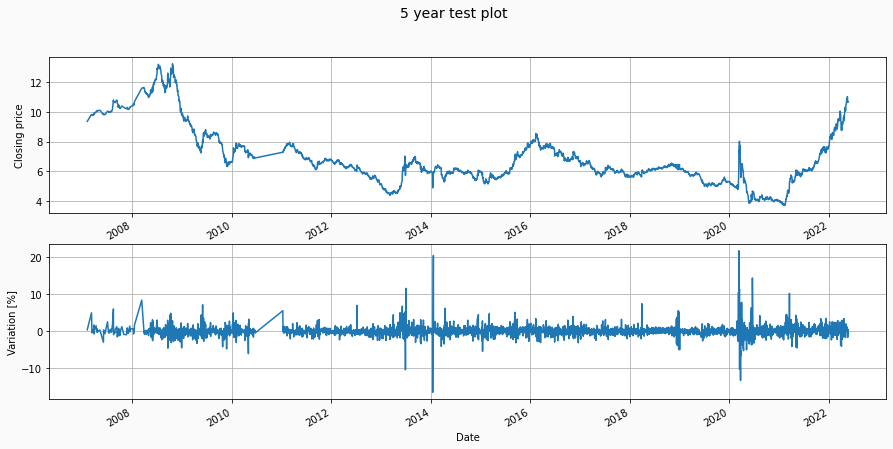

In [11]:
fig1, axes1 = plt.subplots(nrows=2, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig1.suptitle('5 year test plot', fontsize=14)
ax1 = df_test5.plot(use_index=True, y='Close', style=['-'], ylabel='Closing price', legend=False, grid=True, ax=axes1[0]);
ax2 = df_test5.plot(use_index=True, y='Variation', style=['-'], ylabel='Variation [%]', legend=False, grid=True, ax=axes1[1]);

--

## Dotted Plot

Again, the dot plot allows us to see in a little more detail the gap between one sample and another, also allowing us to get an idea of how missing data can affect the around 16 years of information we have.

<Figure size 432x288 with 0 Axes>

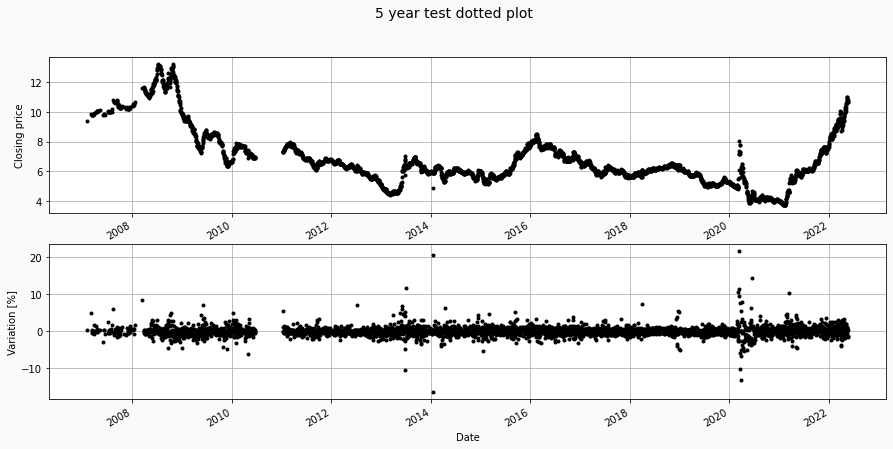

In [12]:
plt.figure()
fig2, axes2 = plt.subplots(nrows=2, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig2.suptitle('5 year test dotted plot', fontsize=14)
ax3 = df_test5['Close'].plot(style='k.', grid=True, ylabel='Closing price', ax=axes2[0]);
ax4 = df_test5['Variation'].plot(style='k.', grid=True, ylabel='Variation [%]', ax=axes2[1]);

## Histogram of Prices and Returns

Subsequently, we proceed to generate the histogram of our data to make a distribution analysis.

The share price, particularly due to its behavior, presents a multimodal distribution. However, from these data it can be deduced that the current control point (higher frequency) is approximately 4,400 pesos, which has been the approximate value of the share since 2016, ranging between approximately 4,000 and 5,000 pesos.

On the other hand, the variation shows an apparently normal distribution with some very extreme points that reach below -10% and reach almost 10%.

<Figure size 432x288 with 0 Axes>

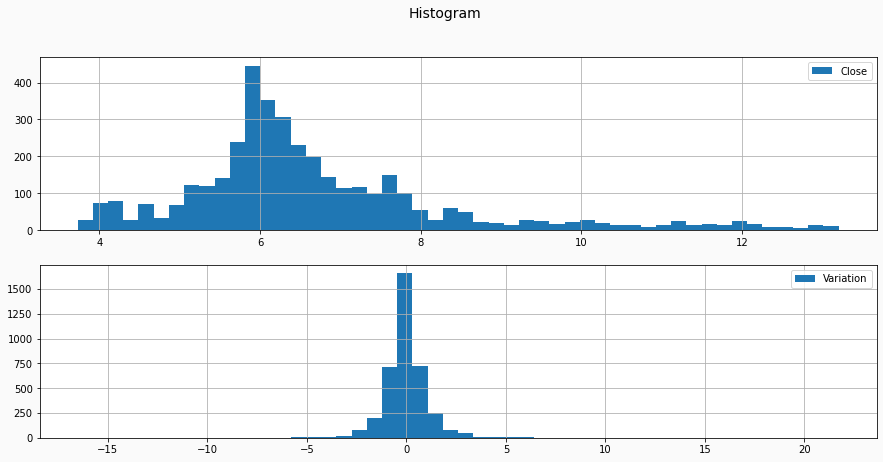

In [13]:
plt.figure()
fig3, axes3 = plt.subplots(nrows=2, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig3.suptitle('Histogram', fontsize=14)
ax5 = df_test5['Close'].hist(bins=50, legend=True, ax=axes3[0]);
ax6 = df_test5['Variation'].hist(bins=50, legend=True, ax=axes3[1]);

## Kernel Density Plot

Continuing with the previous analysis, a better way to understand the behavior of the price and the variation is by analyzing its density, which by smoothing some data gives us an idea of the distribution of the data and allows us to analyze where the confluence has been greater.

<Figure size 432x288 with 0 Axes>

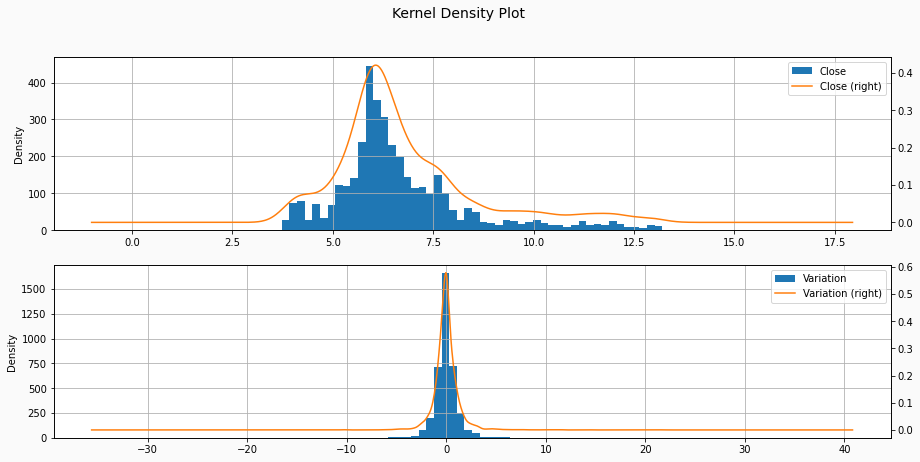

In [14]:
plt.figure()
fig4, axes4 = plt.subplots(nrows=2, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig4.suptitle('Kernel Density Plot', fontsize=14)
ax5 = df_test5['Close'].plot(kind='hist', bins=50, legend=True, ax=axes4[0])
ax5 = df_test5['Variation'].plot(kind='hist', bins=50, legend=True, ax=axes4[1])
ax6 = df_test5['Close'].plot(kind='kde', grid=True, legend=True, ax=axes4[0], secondary_y=True);
ax6 = df_test5['Variation'].plot(kind='kde', grid=True, legend=True, ax=axes4[1], secondary_y=True);

## Plotting Moving Average

--
However, applying low-order filtering models implies, although a low computational cost, a high temporal distortion in the series, since it generates pieces in the sample that, even with a low variation system like this, can generate problems in the prediction system.

<AxesSubplot:xlabel='Date', ylabel='Closing price'>

<Figure size 432x288 with 0 Axes>

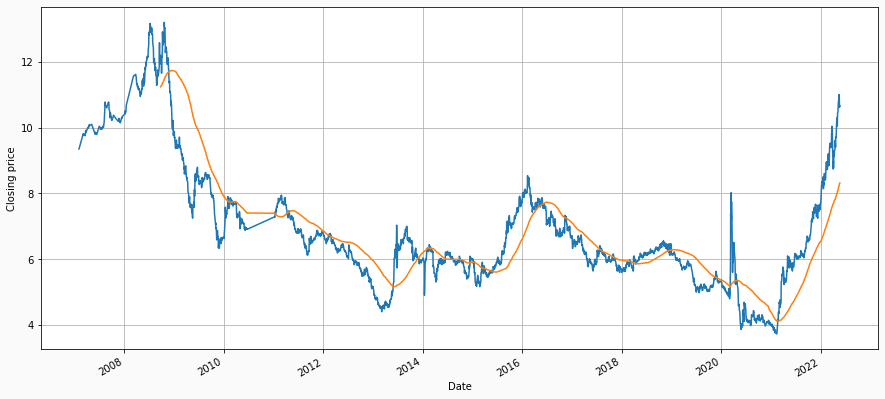

In [15]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig4.suptitle('Plotting Moving Average', fontsize=14)

ax1 = df_test5.plot(use_index=True, y='Close', style=['-'], ylabel='Closing price', legend=False, grid=True, ax=axes)
price_mean = df_test5['Close'].rolling(200, win_type=None).mean()
price_mean.plot(style=['-', '--', ':'], grid=True, ylabel='Closing price', ax=axes)

Just to see the performance for smaller observation windows, it is tested with windows of 50 periods. However, the impact of the temporal displacement generated by this type of implementation continues to be evident.

<Figure size 432x288 with 0 Axes>

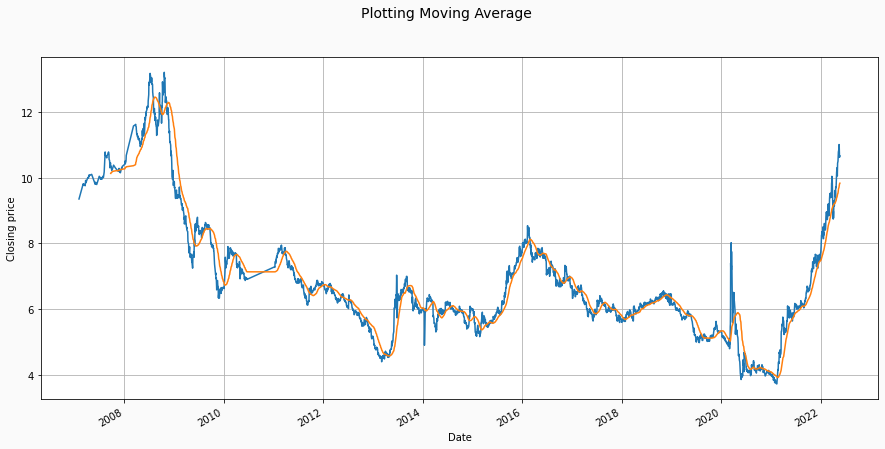

In [16]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig.suptitle('Plotting Moving Average', fontsize=14)

ax1 = df_test5.plot(use_index=True, y='Close', style=['-'], ylabel='Closing price', legend=False, grid=True, ax=axes);
price_mean = df_test5['Close'].rolling(50, win_type=None).mean()
price_mean.plot(style=['-', '--', ':'], grid=True, ax=axes);

## Exponential Smoothing

In search of reducing the noise of the data, the exponential smoothing filter allows to mitigate the noise without very large implications in time shifts compared to the real data.

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<Figure size 432x288 with 0 Axes>

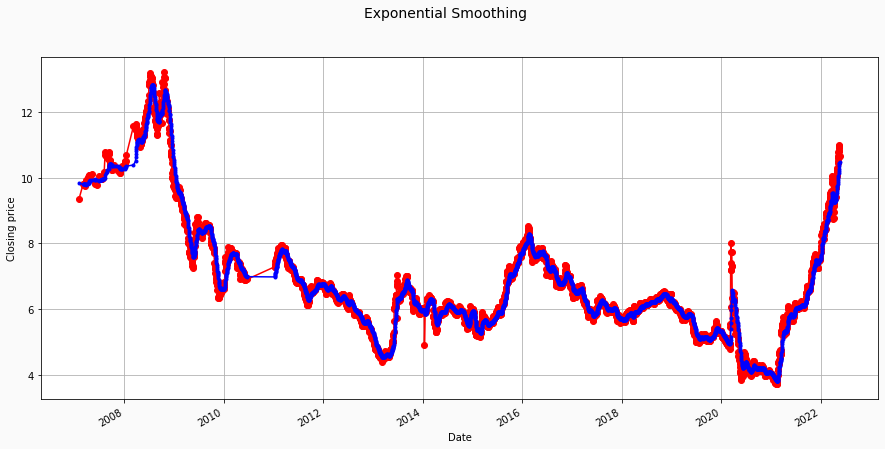

In [17]:
model = SimpleExpSmoothing(df_test5['Close']).fit(smoothing_level=.1, optimized=True)

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig.suptitle('Exponential Smoothing', fontsize=14)
ax = df_test5['Close'].plot(marker='o', color='red', ylabel='Closing price', ax=axes);
model.fittedvalues.plot(marker='.', color='blue', grid=True, ax=axes);

## Lag plot 

Lag plot allows to do a price analysis between the observation of the sample in *t* and *t+1* where it is tried to verify if there is any pattern that shows that the series is not random, in other words to verify the existence of correlation between the samples. In the case of the closing price of the CELSIA share, there is a positive correlation, which finally implies that its behavior can be modeled.

<Figure size 432x288 with 0 Axes>

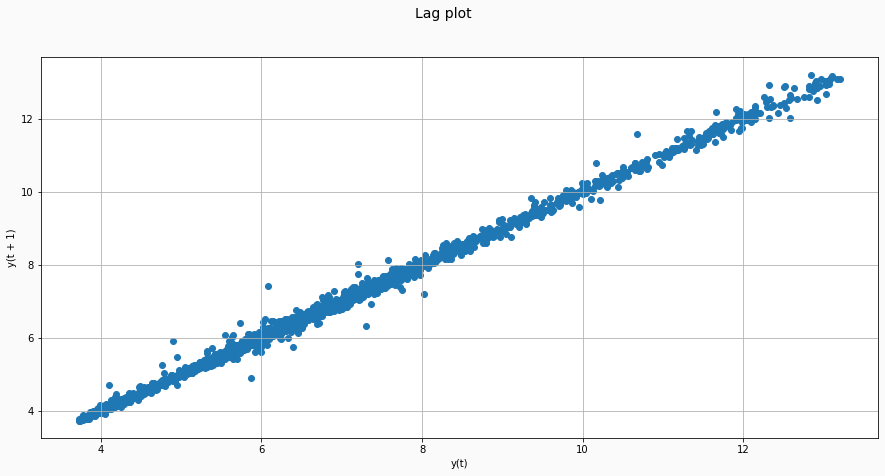

In [18]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig.suptitle('Lag plot ', fontsize=14)
ax = lag_plot(df_test5['Close'], lag=1, ax=axes);
ax.grid()

## Autocorrelation Plot

Finally for the autocorrelation graph, and as expected for a system with such little variation, it seems to be apparently independent of time, despite logic telling us otherwise, it is an important factor to take into account in case At the moment we have problems of autocorrelated variables.

<Figure size 432x288 with 0 Axes>

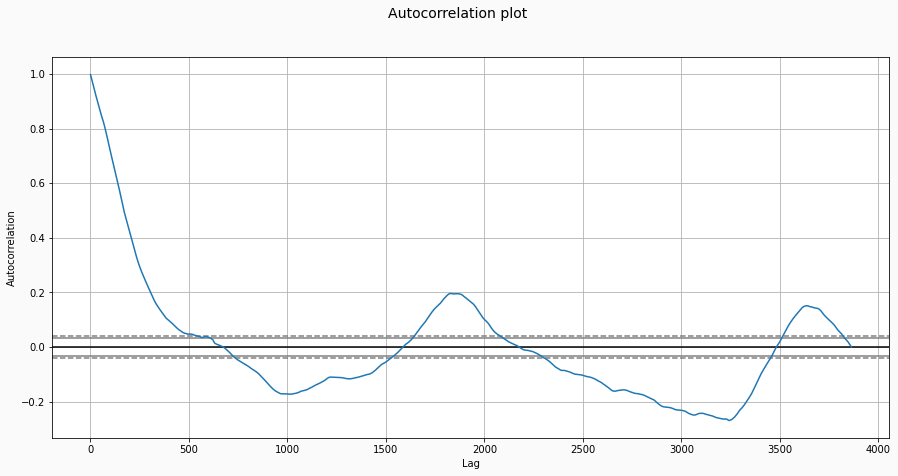

In [19]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig.suptitle('Autocorrelation plot', fontsize=14)
autocorrelation_plot(df_test5['Close'], ax=axes);

## Distribution of the other parameters
Although until now the analysis has been done only of the closing price and the returns, since they are the variables of greatest interest at an economic level; For data science analysis, it is important to have a notion of all the variables, so an analysis of the distribution of the other parameters will be made.

<Figure size 432x288 with 0 Axes>

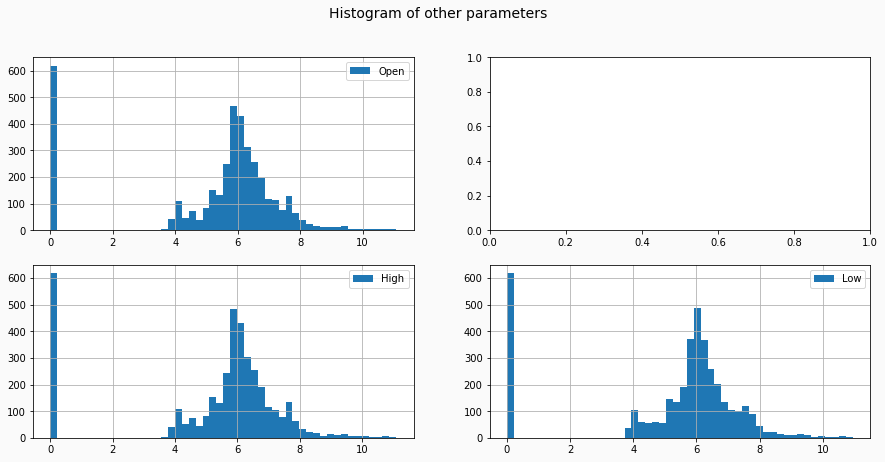

In [20]:
plt.figure()
fig3, axes3 = plt.subplots(nrows=2, ncols=2, figsize=(15, 7), facecolor=(.98, .98, .98))
fig3.suptitle('Histogram of other parameters', fontsize=14)
ax5 = df_test5['Open'].hist(bins=50, legend=True, ax=axes3[0,0]);
ax6 = df_test5['High'].hist(bins=50, legend=True, ax=axes3[1,0]);
ax6 = df_test5['Low'].hist(bins=50, legend=True, ax=axes3[1,1]);

It can be seen that for all the monetary values (`Open`, `High` and `Low`), although their numerical values vary, they have a distribution very similar to that of the closing price, on the other hand the `Volume` is very skewed to the left, this can be analyzed with the interquartile values, which gets much larger as you move between quartiles.

## Variation analysis of clossing price and volume per year
The idea is to check if it is possible to find repetitive patterns in annual periods.

<Figure size 432x288 with 0 Axes>

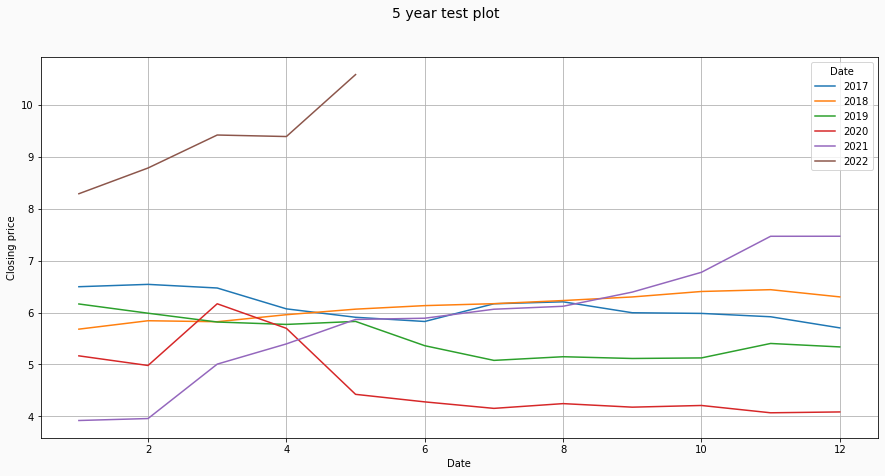

In [21]:
plt.figure()
fig1, axes1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 7), facecolor=(.98, .98, .98))
fig1.suptitle('5 year test plot', fontsize=14)

df_aux = df_test5.loc['2017-01-01':]
pv = pd.pivot_table(df_aux, index=df_aux.index.month, columns=df_aux.index.year, values='Close', aggfunc='mean')
ax1 = pv.plot(use_index=True, style=['-'], ylabel='Closing price', grid=True, ax=axes1)

Despite the fact that there is no predominant or very noticeable pattern, there is an affectation in the number of shares sold, prior to the start of the pandemic, but an unexpected stability in the closing value of the share in the pandemic period.

## Seasonal subseries plot
Finally, an interesting analysis to perform on the time series is a seasonal price analysis of both the stock's closing price and its sales volume.

In [22]:
years = df_test5['Year'].unique()
close_yearly = pd.DataFrame()
for y in years:
    df_aux = df_test5[df_test5['Year']==y].groupby('Month')[['Close']].mean()
    close_yearly = pd.concat([close_yearly, df_aux[['Close']].T.set_index(pd.Index([y]))])

In [23]:
close_yearly_mean = pd.DataFrame()
for y in years:
    close_yearly_mean[y] = close_yearly.mean()

<Figure size 432x288 with 0 Axes>

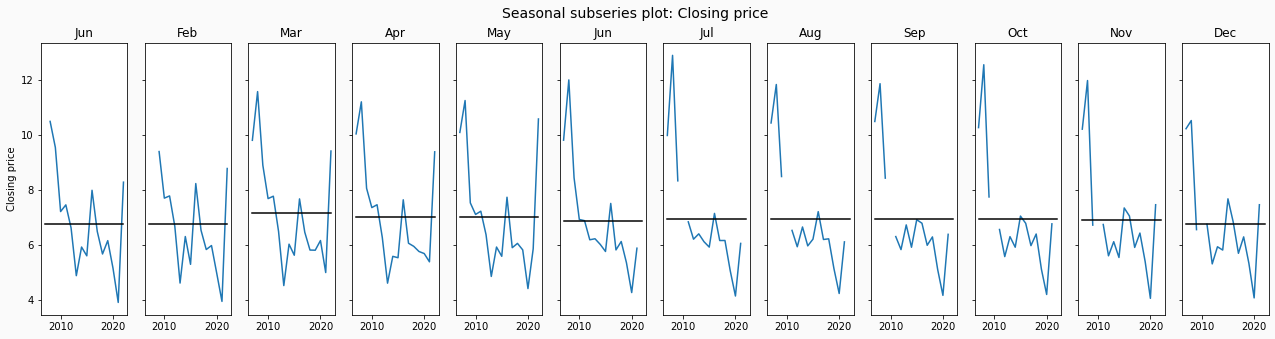

In [24]:
months = ['Jun', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure()
fig1, axes1 = plt.subplots(nrows=1, ncols=12, figsize=(22, 5), sharey=True, facecolor=(.98, .98, .98))
fig1.suptitle('Seasonal subseries plot: Closing price', fontsize=14)
for i in close_yearly:
    close_yearly[i].plot(grid=True, legend=False, title=months[i-1], ylabel='Closing price', ax = axes1[i-1]);
    close_yearly_mean.T[i].plot(legend=False, ax = axes1[i-1], color ='k');

In [25]:
path_out = '../data/dev/TES 5 años.csv'
df_test5.to_csv(path_out, encoding='utf-8')